# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
import pickle
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA, FastICA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore
from scipy.signal import savgol_filter

# LSTM Model imports
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)

# Get the current directory of the notebook
notebook_dir = os.getcwd()


Using device: cpu


In [189]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

### Preprocessing Data
Function to preprocess the data. 

In [190]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

### Pivoting Frequency values to columns

In [191]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [192]:
# Load the data from the directory
input_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/experiment_5_plastics/processed'))

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(4)

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.366256,24.172872,A
1,100.0,-0.244170,37.846416,A
2,100.0,-1.831278,42.241484,A
3,100.0,1.220852,36.015138,A


## Balance Dataset

In [193]:
# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)


Mean value: 5088


### Sample a test set

In [194]:
df_train = df_balanced.copy()

test_percentage = 0.2

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()


,Frequency (GHz),LG (mV),HG (mV),Sample
2664042,170.0,19.045293,-0.244141,L
2671473,230.0,1.953363,778.049088,L
1902336,320.0,0.976682,229.886436,H
1288617,370.0,1.709193,312.049830,F
2682846,310.0,0.976682,510.804558,L


### Data Windowing

In [195]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 4
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()


Data percentage: 0.26041666666666663%
Data percentage test: 1.0416666666666665%


## Prepare Training Data
### Split data into X and y


In [196]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False, eliminate_LG=False, drop_sample=True):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    if eliminate_LG:
        # Eliminate LG columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'LG' in col])

    return X_, y_


### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting
- Support Vector Machine

In [197]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=1000,
                                  random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

def support_vector_machine_model(X_train, y_train, seed):
    svm_model = SVC(random_state=seed)
    svm_model.fit(X_train, y_train)
    return svm_model


### Train all Models

In [198]:
def train_models(X_train, y_train, seed):
    training_times = []
    
    # Random Forest
    start_time = time.time()
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)
    
    # Naive Bayes
    start_time = time.time()
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)
    
    # Logistic Regression
    start_time = time.time()
    lr_model = LogisticRegression(random_state=seed, max_iter=1000)
    lr_model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)
    
    # Gradient Boosting
    start_time = time.time()
    gb_model = GradientBoostingClassifier(random_state=seed)
    gb_model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)
    
    # SVM
    start_time = time.time()
    svm_model = SVC(random_state=seed)
    svm_model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)
    
    return rf_model, nb_model, lr_model, gb_model, svm_model, training_times

def save_models(rf_model, nb_model, lr_model, gb_model, svm_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')
    joblib.dump(svm_model, 'support_vector_machine_model.pkl')


In [199]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.7):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [200]:
# AIC Criteria
def aic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    aic = 2 * n_features + n * np.log((rss + epsilon) / n)
    return aic

# BIC Criteria (Also consider the number of samples)
def bic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    bic = np.log(n) * n_features + n * np.log((rss + epsilon) / n)
    return bic

In [201]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions,
                        n_features, freqs, aic_scores, bic_scores, training_times=None, 
                        inference_times=None, csv_path='comparison_results.csv', verbose=0):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Initialize timing data if not provided
    if training_times is None:
        training_times = [0] * len(models)
    if inference_times is None:
        inference_times = [0] * len(models)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'AIC': aic_scores,
        'BIC': bic_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models),
        'Training_Time': training_times,
        'Inference_Time_Per_Sample': inference_times
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AIC', 'BIC', 
                    'Training_Time', 'Inference_Time_Per_Sample']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    if verbose >= 1:
        print(f"\nTest #{current_test} Results:")
        print(results_df)
        if verbose >= 2:
            print("\nAll Results:")
            print(updated_results)
        
    return updated_results

In [202]:
def evaluate_models(y_test, y_pred, verbose=0):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aic_scores = []
    bic_scores = []
    predictions_list = []

    # Label encode y_test
    le = LabelEncoder()
    le.fit(y_test)

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_i, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_i, average='weighted', zero_division=0)

        # Calculate AIC and BIC
        y_test_num = le.transform(y_test)
        y_pred_num = le.transform(y_pred_i)
        n_features = len(y_pred_i)
        aic = aic_score(y_test_num, y_pred_num, n_features)
        bic = bic_score(y_test_num, y_pred_num, n_features)

        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))

        print(f"Model {i+1} - Accuracy: {accuracy}")

        if verbose >= 1:
            print(f"Model {i+1} - Precision: {precision}")
            print(f"Model {i+1} - Recall: {recall}")
            print(f"Model {i+1} - F1: {f1}")
            print(f"Model {i+1} - AIC: {aic}")
            print(f"Model {i+1} - BIC: {bic}")
            print(f"Model {i+1} - Predictions: {predictions}\n")
            if verbose >= 2:
                # Classification report
                print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')


        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aic_scores.append(aic)
        bic_scores.append(bic)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions_list

In [203]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


### Confusion Matrix

In [204]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=7, 
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


In [276]:
def plot_confusion_matrix_pdf(y_true, y_pred, labels, save_path=None, model_name=None):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap=plt.cm.Blues
    cax = ax.matshow(conf_matrix, cmap=cmap)
    fig.colorbar(cax)
    
    # Determine text color based on cell value for better visibility
    for i in range(len(labels)):
        for j in range(len(labels)):
            # Calculate percentage
            percentage = conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100 if np.sum(conf_matrix, axis=1)[i] > 0 else 0
            
            # Determine text color based on cell darkness
            cell_value = conf_matrix[i, j]
            if cell_value > conf_matrix.max() / 3:
                text_color = 'white'

                plt.text(j, i, f'{conf_matrix[i, j]}\n{percentage:.1f}%',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=8, 
                     ha='center', va='center', 
                     color=text_color)
            else:
                text_color = cmap(1.0)

                if conf_matrix[i, j] != 0:

                    plt.text(j, i, f'{conf_matrix[i, j]}\n{percentage:.1f}%',
                        horizontalalignment="center",
                        verticalalignment="center",
                        fontsize=8, 
                        ha='center', va='center', 
                        color=text_color)
            

    
    plt.xlabel('Predicted', fontweight='bold', fontsize=12)
    plt.ylabel('True', fontweight='bold', fontsize=12)
    plt.xticks(np.arange(len(labels)), labels, rotation=45, fontweight='bold')
    plt.yticks(np.arange(len(labels)), labels, fontweight='bold')
    plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
        
    # Adjust layout to make room for rotated x labels
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        # Create directory if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # Create filename
        model_suffix = f"_{model_name}" if model_name else ""
        filename = f"confusion_matrix{model_suffix}.pdf"
        filepath = os.path.join(save_path, filename)
        
        # Save as PDF
        plt.savefig(filepath, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Confusion matrix saved to: {filepath}")
    
    plt.show()
    

In [205]:
def add_features(X, y, subset_freqs, HG_diff=True, LG_diff=True):

    X['Sample'] = y

    # Initialize a dictionary to store results
    mean_std_dict = {}

    for freq in subset_freqs:
        # Calculate HG and LG mean values for each frequency
        agg_dict = {}
        if f'{freq}.0 LG (mV) mean' in X.columns:
            agg_dict['LG_mean'] = (f'{freq}.0 LG (mV) mean', 'mean')
        if f'{freq}.0 HG (mV) mean' in X.columns:
            agg_dict['HG_mean'] = (f'{freq}.0 HG (mV) mean', 'mean')
        
        mean_std_dict[freq] = X.groupby('Sample').agg(**agg_dict).reset_index()

        mean_std_dict[freq]['Frequency'] = freq

    # Concatenate all DataFrames in the dictionary
    mean_std_df = pd.concat(mean_std_dict.values(), ignore_index=True)

    # For each frequency after first one
    for i, freq in enumerate(subset_freqs[1:]):
        prev_freq = subset_freqs[i]  # Get previous frequency
        
        # For each row
        for idx, row in X.iterrows():
            sample = row['Sample']
            
            if HG_diff:
                # Get previous frequency's HG mean for this sample
                prev_hg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['HG_mean'].values[0]


                # 1) Inputs: xt - (xt-1) --First-order differences
                # 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

                # Calculate and store difference
                X.loc[idx, f'{freq}.0 HG diff'] = X.loc[idx, f'{freq}.0 HG (mV) mean'] - prev_hg
                # X.loc[idx, f'{freq}.0 HG relative diff'] = (X.loc[idx, f'{freq}.0 HG (mV) mean'] / prev_hg) -1


            if LG_diff:
                prev_lg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['LG_mean'].values[0]

                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 LG diff'] = X.loc[idx, f'{freq}.0 LG (mV) mean'] - prev_lg
                X.loc[idx, f'{freq}.0 LG relative diff'] = (X.loc[idx, f'{freq}.0 LG (mV) mean'] / prev_lg) -1


    # Drop the 'Sample' column
    X = X.drop(columns=['Sample'])

    return X
  

### Load New Test Data
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [206]:
input_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/experiment_5_plastics/processed/new_sample'))

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 1
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")
# print(f"X_shape: {X_train.shape}")

# le = LabelEncoder()

# # save label encoder
# joblib.dump(le, 'label_encoder.pkl')

# # load the label encoder
# le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0  0.000000  36.625564      A
1            100.0 -0.488341  17.214015      A
2            100.0  0.000000  35.160542      A
3            100.0  1.587108  32.840922      A
4            100.0  2.075449  46.636552      A
5            100.0  0.732511  32.840922      A
6            100.0  0.000000  37.968501      A
7            100.0  0.610426  37.235990      A
8            100.0  0.244170  40.288121      A
9            100.0  1.098767  35.770968      A
Data percentage: 1.0416666666666665%
Data percentage test: 4.166666666666666%
New sample shape: (1158, 201)


## Define training and testing data

In [280]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

freqs = []

# Favourite frequencies
# freqs.append([250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]) # TOP 25
# freqs.append([250,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,540]) # TOP 24

# freqs.append([310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,540]) # TOP 20 88% SG(3,2)
# freqs.append([310,320,330,340,350,360,370,400,410,420,430,440,450,460,470,480,490,500,510,540]) # TOP 20 88% SG(3,2)
# freqs.append([300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490]) # TOP 20 88% SG(3,2)

# freqs.append([310,320,330,340,350,360,370,380,390,400,410,420]) # TOP 12 (86%)
freqs.append([310,320,330,340,350,360,370,400,410,420]) # TOP 10 (88%)
freqs.append([330,340,350,360,410]) # TOP 5 86% SG

# freqs.append([340,350,360]) # TOP 3
# freqs.append([350]) # TOP 1


# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
# freqs.extend([
#     [250, 300, 320],
#     [300, 310, 320],
#     [330, 340, 350],
#     [360, 370, 380],
#     [390, 400, 410],
#     [420, 430, 440]
# ])

# Add all frequencies one by one
# for i in range(250, 501, 10):
#     freqs.append([i])

# # Add groups of 2 frequencies
# for i in range(300, 411, 20):
#     if i + 10 <= 350:
#         freqs.append([i, i+10])

# # Add groups of 3 frequencies
# for i in range(250, 441, 30):
#     if i + 20 <= 590 and i + 10 <= 590:
#         freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
# freqs.append(list(range(100, 591, 10)))

# freqs.append([250,320,330,410])

# freqs = freqs_fav ## TESTING

print(freqs)

[[310, 320, 330, 340, 350, 360, 370, 400, 410, 420], [330, 340, 350, 360, 410]]


In [208]:
def inference_sampling(predictions):
    """
    Takes a list of predictions and returns the most common value
    Args: predictions: List of prediction values
    Returns: Most frequent prediction value
    """
    if not predictions:
        return None
        
    # Count frequency of each prediction
    freq_dict = {}
    for pred in predictions:
        freq_dict[pred] = freq_dict.get(pred, 0) + 1
    
    # Find value with highest frequency
    max_freq = 0
    mode = None
    for value, freq in freq_dict.items():
        if freq > max_freq:
            max_freq = freq
            mode = value
            
    return mode

In [209]:
def predict_with_probabilities(model, X):
    """
    Perform inference on the dataset using the trained model and return predictions with probabilities.

    Parameters:
    model: Trained model object with predict and predict_proba methods.
    X: Dataset to perform inference on.

    Returns:
    predictions: Array of predicted class labels.
    probabilities: Array of predicted probabilities for each class.
    """
    # Predict class labels
    predictions = model.predict(X)
    
    # Predict probabilities
    probabilities = model.predict_proba(X)
    
    return predictions, probabilities

In [210]:
def evaluate_models_with_sampling(models, X, y_true):
    """
    Evaluate multiple models using inference sampling
    
    Args:
        models: List of trained model objects
        X: Features dataset
        y_true: True labels
        
    Returns:
        Dictionary with evaluation metrics
    """
        
    # Get predictions from each model
    all_predictions = []
    for model in models:
        preds, _ = predict_with_probabilities(model, X)
        all_predictions.append(preds)
    
    # Get final predictions using sampling
    final_predictions = []
    for i in range(len(X)):
        sample_preds = [pred[i] for pred in all_predictions]
        final_pred = inference_sampling(sample_preds)
        final_predictions.append(final_pred)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, final_predictions),
        'precision': precision_score(y_true, final_predictions, average='weighted'),
        'recall': recall_score(y_true, final_predictions, average='weighted'),
        'f1': f1_score(y_true, final_predictions, average='weighted')
    }
    
    return metrics

## Testing

Training
Frequency: [310, 320, 330, 340, 350, 360, 370, 400, 410, 420]
Model 1 - Accuracy: 1.0
Model 2 - Accuracy: 1.0
Model 3 - Accuracy: 1.0
Model 4 - Accuracy: 0.9982758620689656
Model 5 - Accuracy: 0.9974137931034482
Model 1 - Accuracy: 0.6381692573402418
Model 2 - Accuracy: 0.8799654576856649
Model 3 - Accuracy: 0.7478411053540587
Model 4 - Accuracy: 0.57426597582038
Model 5 - Accuracy: 0.6243523316062176
Confusion matrix saved to: c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\data\results\conf_matrix\confusion_matrix_NB_[310, 320, 330, 340, 350, 360, 370, 400, 410, 420].pdf


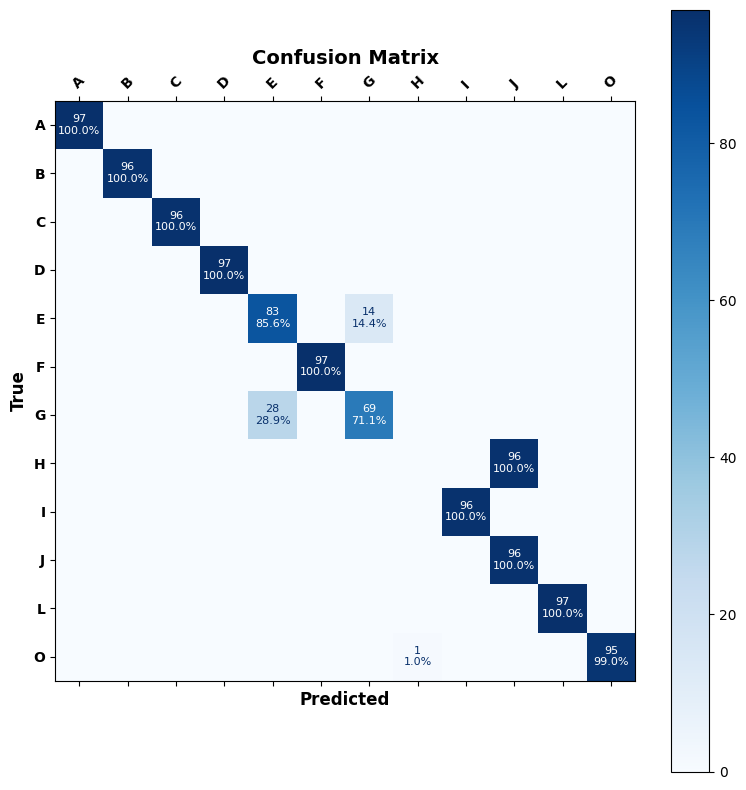

Frequency: [330, 340, 350, 360, 410]


In [ ]:
csv_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/results/exp_5/results_12p_01.csv'))

# Training options
drop_sample = True
eliminate_std_dev = False
eliminate_LG = False
HG_diff = False
LG_diff = False
apply_scaling = False
apply_savitzky_golay = True
apply_pca = False
apply_lda = False 
apply_qda = False
apply_ica = False

print(f'Training')

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')
    
    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    # Apply standard scaling
    if apply_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if apply_savitzky_golay:
        X_train = savgol_filter(X_train, window_length=5, polyorder=3)
        X_test = savgol_filter(X_test, window_length=5, polyorder=3)

    if apply_pca:
        pca = PCA(n_components=0.95)  
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    if apply_lda:
        lda = LinearDiscriminantAnalysis()
        X_train = lda.fit_transform(X_train, y_train)
        X_test = lda.transform(X_test)

    if apply_qda:
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train, y_train)
        # Get probability estimates
        X_train_qda = qda.predict_proba(X_train)
        X_test_qda = qda.predict_proba(X_test)
        
        # To combine with original features
        X_train = np.hstack((X_train, X_train_qda))
        X_test = np.hstack((X_test, X_test_qda))


    if apply_ica:
        ica = FastICA(n_components=2)
        X_train = ica.fit_transform(X_train)
        X_test = ica.transform(X_test)

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB', 'SVM']

    # Train the models
    rf_model, nb_model, lr_model, gb_model, svm_model, training_times = train_models(X_train, y_train, seed)

    # Make Predictions
    y_pred = []
    inference_times = []
    for model in [rf_model, 
                  nb_model, 
                  lr_model, 
                  gb_model, 
                  svm_model]:
        start_time = time.time()
        predictions = model.predict(X_test)
        total_time = time.time() - start_time
        inference_times.append(total_time / len(X_test))  # Time per sample
        y_pred.append(predictions)
    
        
    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='test',
        # transformations=transformations,
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path,
        training_times=training_times,
        inference_times=inference_times
    )


    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_new_sample = add_features(X_new_sample, y_new_sample, subset_freqs, HG_diff, LG_diff)


    if apply_scaling:
        X_new_sample = scaler.transform(X_new_sample)

    if apply_savitzky_golay:
        X_new_sample = savgol_filter(X_new_sample, window_length=5, polyorder = 3)

    if apply_pca:
        X_new_sample = pca.transform(X_new_sample)

    if apply_qda:
        X_new_sample_qda = qda.predict_proba(X_new_sample)
        X_new_sample = np.hstack((X_new_sample, X_new_sample_qda))
                                  
    if apply_lda:
        X_new_sample = lda.transform(X_new_sample)

    if apply_ica:
        X_new_sample = ica.transform(X_new_sample)

    # Make Predictions
    y_pred_ns = []
    inference_times_ns = []
    for model in [rf_model, 
                    nb_model, 
                    lr_model, 
                    gb_model, 
                    svm_model]:
            start_time = time.time()
            predictions = model.predict(X_new_sample)
            total_time = time.time() - start_time
            inference_times_ns.append(total_time / len(X_new_sample))  
            y_pred_ns.append(predictions)
    

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, verbose=0)

    # Plot Confusion Matrix of good models
    save_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/results/conf_matrix/'))

    for i, accuracy in enumerate(accuracies):
        if accuracy >= 0.8:
            model_name = f"{models[i]}_{freq}"
            # plot_confusion_matrix(y_new_sample, y_pred_ns[i], np.unique(y_train))
            plot_confusion_matrix_pdf(y_new_sample, y_pred_ns[i], np.unique(y_train), save_path, model_name)

    updated_results = save_model_results(
        models=models,
        data='new_sample',
        # transformations=transformations,
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path,
        training_times=training_times,
        inference_times=inference_times_ns
    )


### Principal Component Analysis

Frequency: [310, 320, 330, 340, 350, 360, 370, 400, 410, 420]


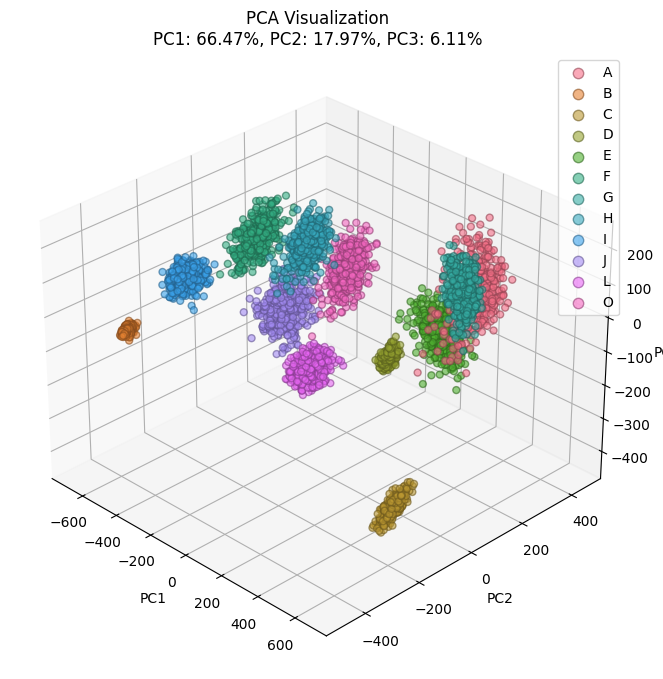

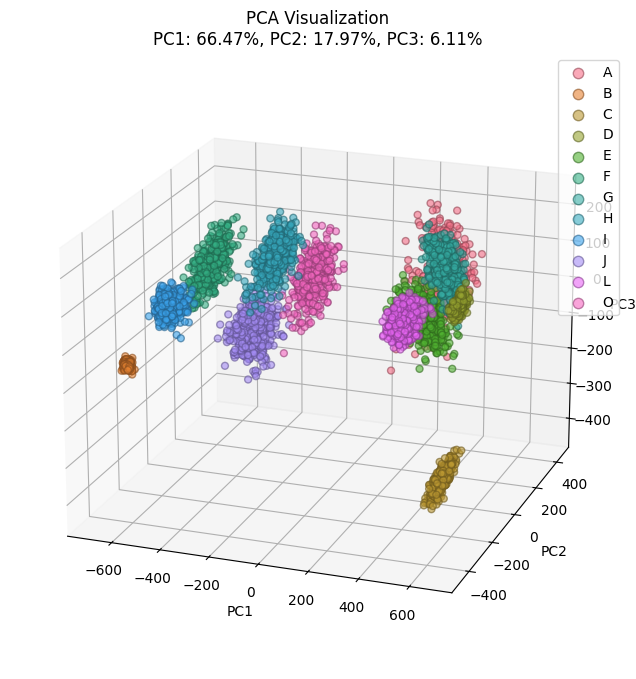

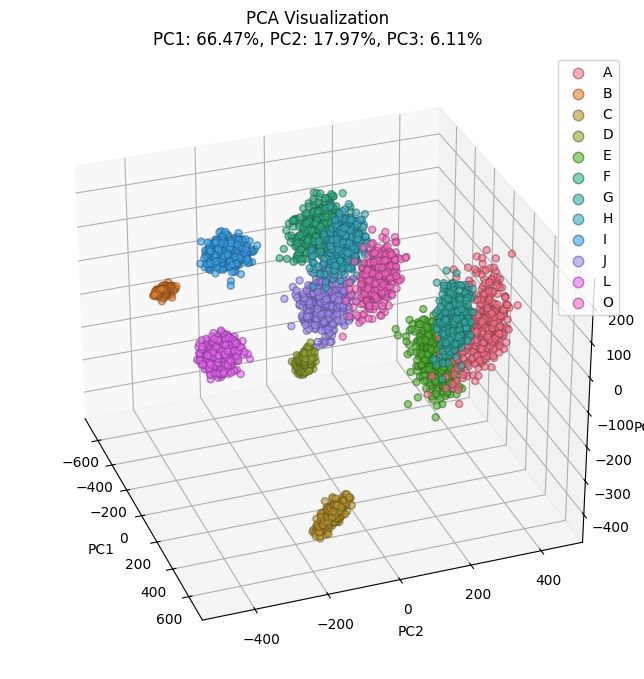

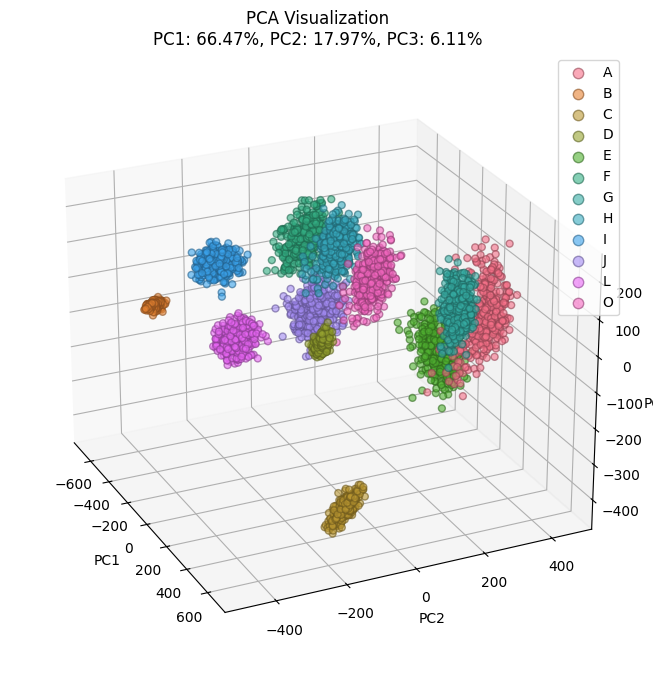

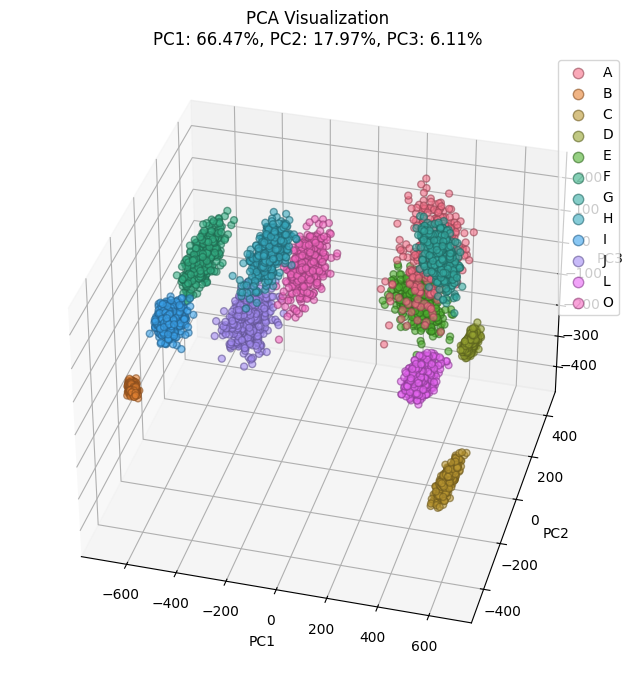

Frequency: [330, 340, 350, 360, 410]


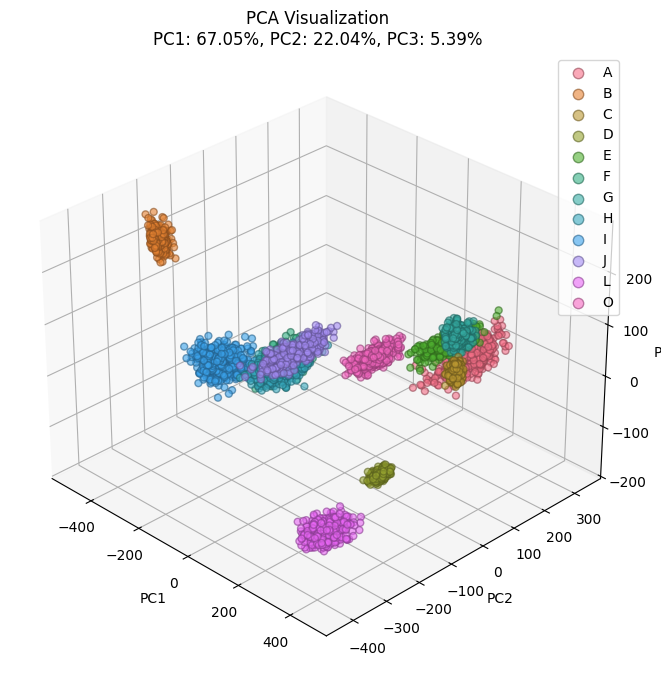

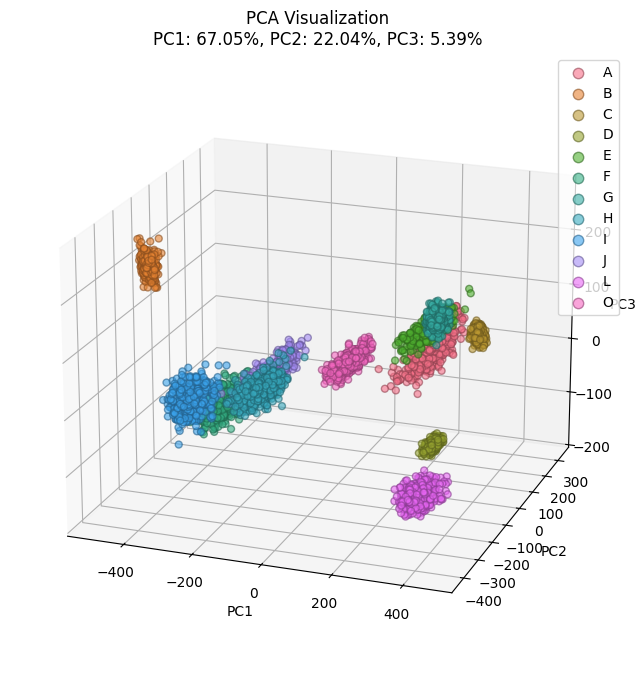

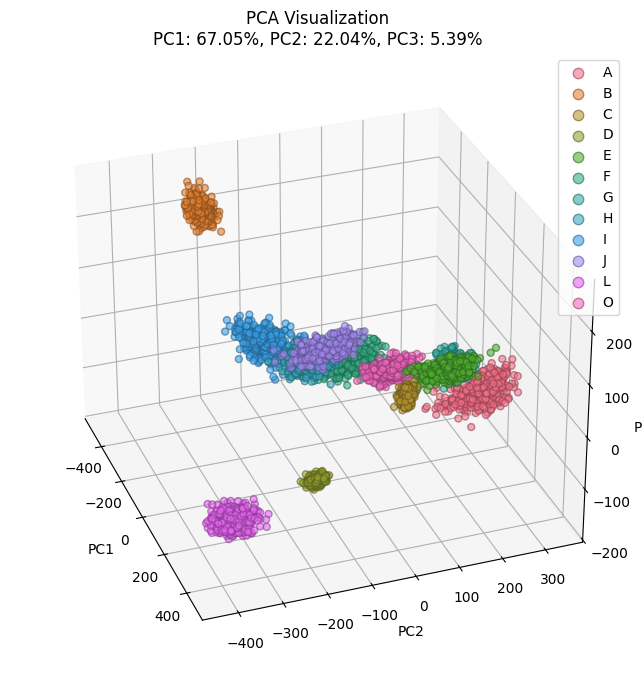

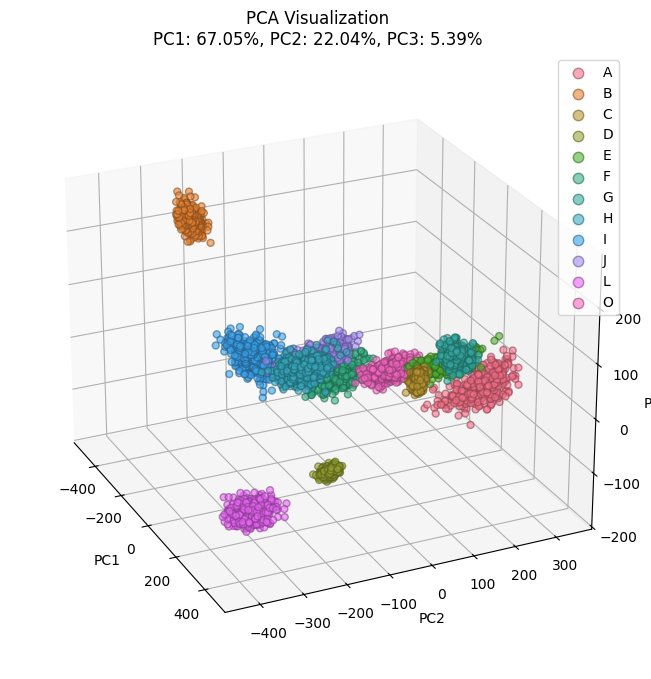

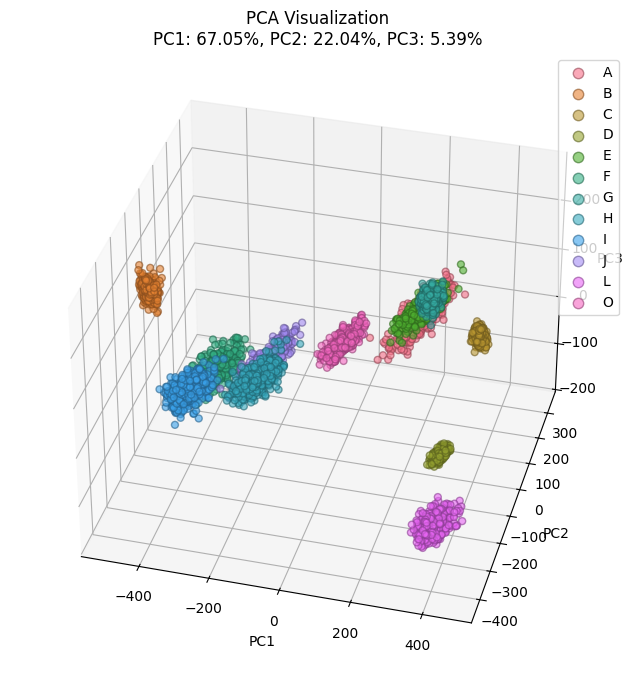

In [248]:
def adjust_color_brightness(color, factor=0.6):
    return tuple([min(1, max(0, c * factor)) for c in color])

def plot_pca_3d(X_train_pca, y_pca, elev=30, azim=-45, show_labels=True):
    """
    Plot PCA results in 3D, 2D, or 1D depending on the number of components.
    
    Parameters:
    -----------
    X_train_pca : array
        PCA-transformed data
    y_pca : array
        Labels for each point
    elev : float, default=30
        Elevation angle for 3D plot viewing
    azim : float, default=-45
        Azimuth angle for 3D plot viewing
    show_labels : bool, default=True
        Whether to show labels at the centroid of each class
    """
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_pca)
    unique_classes = np.unique(y_encoded)
    n_classes = len(unique_classes)
    
    # Define color palette using Seaborn's husl palette
    base_palette = sns.color_palette("husl", n_classes)
    
    # Create a mapping of labels to colors
    color_dict = {}
    for i, label in enumerate(le.classes_):
        color_dict[label] = base_palette[i]
    
    # Get number of components
    n_components = X_train_pca.shape[1]
    fig = plt.figure(figsize=(10, 8))
    
    if n_components >= 3:
        # 3D plot
        ax = fig.add_subplot(111, projection='3d')
        
        # Set the viewing angle
        ax.view_init(elev=elev, azim=azim)
        
        # Plot each class separately
        for i, class_name in enumerate(le.classes_):
            mask = y_pca == class_name
            color = base_palette[i]
            
            # Scatter points
            ax.scatter(X_train_pca[mask, 0], 
                      X_train_pca[mask, 1],
                      X_train_pca[mask, 2],
                      color=color,
                      edgecolor=adjust_color_brightness(color, 0.6),
                      label=class_name,
                      s=25,
                      alpha=0.6)
            
            # Add labels if requested
            if show_labels:
                # Calculate centroid
                centroid = np.mean(X_train_pca[mask], axis=0)
                
                # Use a fixed offset based on viewing angle for label positioning
                offset_factor = 0.2  # Adjust this factor to increase/decrease offset
                
                # Calculate offset based on data range
                data_range = np.ptp(X_train_pca, axis=0)
                
                # Compute an offset that considers the viewing angle
                sin_azim = np.sin(np.radians(azim))
                cos_azim = np.cos(np.radians(azim))
                sin_elev = np.sin(np.radians(elev))
                cos_elev = np.cos(np.radians(elev))
                
                # Calculate offset vector
                offset_x = offset_factor * data_range[0] * sin_azim
                offset_y = offset_factor * data_range[1] * cos_azim
                offset_z = offset_factor * data_range[2] * cos_elev
                
                # Position for label
                label_pos = (centroid[0] + offset_x,
                             centroid[1] + offset_y,
                             centroid[2] + offset_z)
                
                # Draw an arrow from the label to the centroid
                ax.plot([label_pos[0], centroid[0]],
                       [label_pos[1], centroid[1]],
                       [label_pos[2], centroid[2]],
                       'k-', linewidth=1, alpha=0.6)
                
                # Add the label
                ax.text(label_pos[0], label_pos[1], label_pos[2],
                       class_name,
                       fontsize=10,
                       fontweight='bold',
                       color='black',
                       ha='center',
                       va='center',
                       bbox=dict(facecolor='white', 
                                alpha=0.9, 
                                boxstyle='round,pad=0.3',
                                edgecolor='gray'))
        
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        
        # Add grid for better depth perception
        ax.grid(True)
        
    elif n_components == 2:
        # 2D plot
        ax = fig.add_subplot(111)
        
        # Plot each class separately
        for i, class_name in enumerate(le.classes_):
            mask = y_pca == class_name
            color = base_palette[i]
            
            # Scatter points
            ax.scatter(X_train_pca[mask, 0],
                      X_train_pca[mask, 1],
                      color=color,
                      edgecolor=adjust_color_brightness(color, 0.6),
                      label=class_name,
                      s=25, #dot size
                      alpha=0.6)
        
        # Add labels if requested
        if show_labels:
            for i, class_name in enumerate(le.classes_):
                mask = y_pca == class_name
                color = base_palette[i]
                
                # Calculate centroid of this class
                centroid = np.mean(X_train_pca[mask], axis=0)
                
                # Create a marker at centroid location that will be behind the text
                ax.scatter(centroid[0], centroid[1],
                          color='white',
                          s=250,
                          alpha=0.8,
                          edgecolor='gray',
                          zorder=5)  # Higher zorder to ensure it's drawn on top
                
                # Add text label at centroid
                ax.text(centroid[0], centroid[1], 
                        class_name, 
                        fontsize=12, 
                        fontweight='bold', 
                        color='black',
                        ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3', 
                                  edgecolor='gray'),
                        zorder=10)  # Even higher zorder for text
            
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        
    else:
        # 1D plot
        ax = fig.add_subplot(111)
        
        # Plot each class separately
        for i, class_name in enumerate(le.classes_):
            mask = y_pca == class_name
            color = base_palette[i]
            
            # Scatter points
            ax.scatter(X_train_pca[mask, 0],
                      np.zeros_like(X_train_pca[mask, 0]),
                      color=color,
                      edgecolor=adjust_color_brightness(color, 0.6),
                      label=class_name,
                      s=25, #dot size
                      alpha=0.6)
            
            # Add label if requested
            if show_labels:
                # Calculate centroid of this class
                centroid = np.mean(X_train_pca[mask], axis=0)
                
                # Add text label at centroid
                ax.text(centroid[0], 0.05, 
                        class_name, 
                        fontsize=12, 
                        fontweight='bold', 
                        color='black',
                        ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3',
                                 edgecolor='gray'))
            
        ax.set_xlabel('PC1')
        plt.yticks([])
    
    # Add legend with class names
    plt.legend(loc='best', markerscale=1.5)
    
    # Add explained variance ratio to title if available
    if hasattr(pca, 'explained_variance_ratio_'):
        if n_components >= 3:
            variance_text = f'PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}, PC3: {pca.explained_variance_ratio_[2]:.2%}'
        elif n_components == 2:
            variance_text = f'PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}'
        else:
            variance_text = f'PC1: {pca.explained_variance_ratio_[0]:.2%}'
        plt.title(f'PCA Visualization\n{variance_text}')
    else:
        plt.title('PCA Visualization')

    # Save figure with angle and label information in filename
    filepath = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/results/pca_models/'))
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    freqs_code = '_'.join(map(str, subset_freqs))
    labels_suffix = "_labeled" if show_labels else ""
    plt.savefig(f'{filepath}/pca_viz_{freqs_code}_elev{elev}_azim{azim}{labels_suffix}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    return ax


# PCA 3D Visualization
# Generate multiple views of the same PCA result
for freq in freqs:
    subset_freqs = freq
    print(f'Frequency: {freq}')

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    pca = PCA(n_components=0.95)  
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    y_pca = y_train
    
    # Generate different views of the same data
    views = [
        (30, -45),   # Default view
        # (0, 0),      # Front view
        # (0, 90),     # Side view
        # (90, 0),     # Top view
        (20, -70),   # Another interesting angle
        (30, -20),   # Another interesting angle
        (25, -25),   # Another interesting angle
        (35, -75),   # Another interesting angle

    ]
    
    for elev, azim in views:
        plot_pca_3d(X_train_pca, y_pca, elev=elev, azim=azim, show_labels=False)

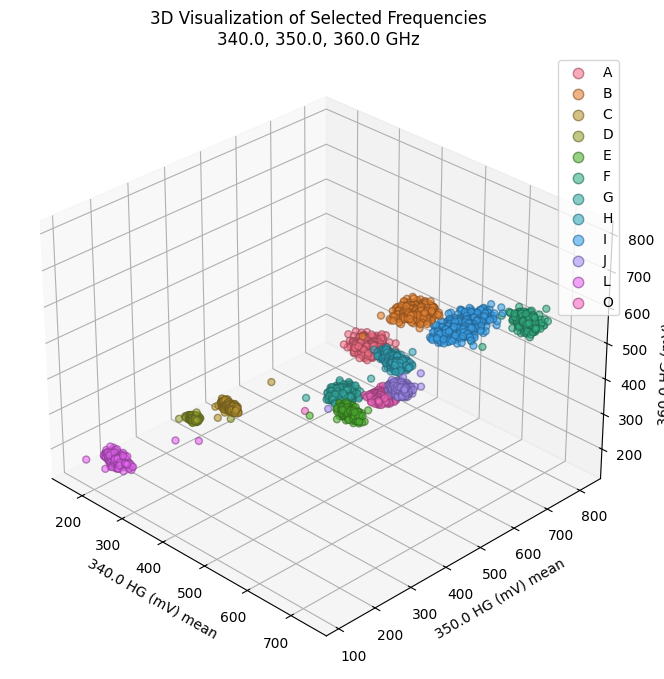

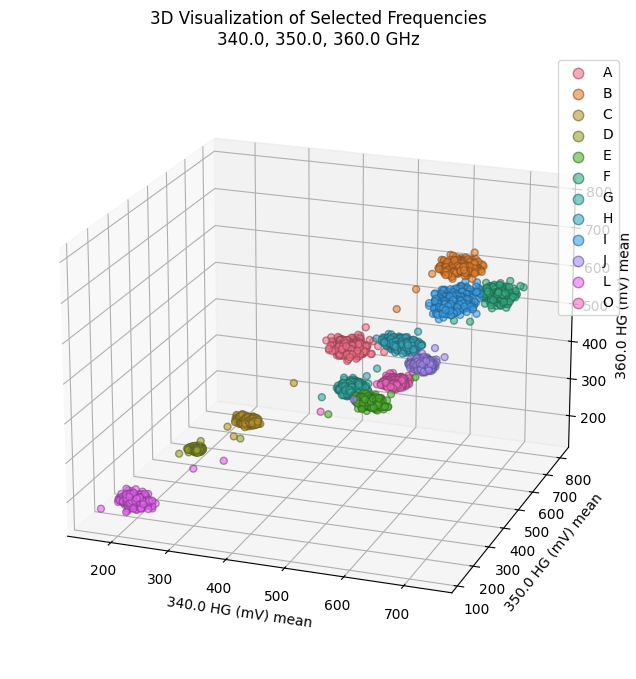

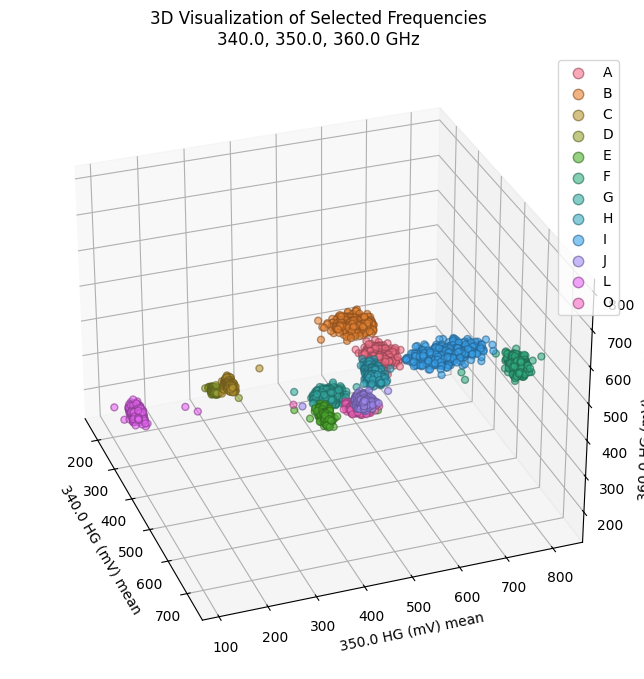

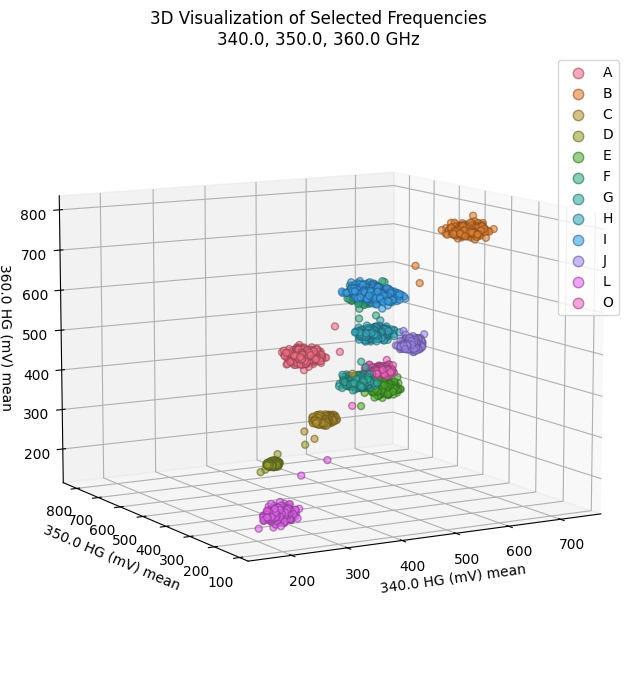

In [242]:
def adjust_color_brightness(color, factor=0.6):
    return tuple([min(1, max(0, c * factor)) for c in color])

def plot_3d_specific_frequencies(df, freq_names, elev=30, azim=-45):
    """
    Plot 3D visualization using 3 selected frequencies directly from the dataframe.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing the frequency data
    freq_names : list
        List of 3 column names to visualize (e.g., ['340.0 HG (mV)', '350.0 HG (mV)', '360.0 HG (mV)'])
    elev : float, default=30
        Elevation angle for 3D plot viewing
    azim : float, default=-45
        Azimuth angle for 3D plot viewing
    """
    # Check if we have 3 frequencies
    if len(freq_names) != 3:
        raise ValueError("Need exactly 3 frequency names for 3D plot")
    
    # Check if frequencies exist in dataframe
    for freq in freq_names:
        if freq not in df.columns:
            raise ValueError(f"Frequency column '{freq}' not found in dataframe")
    
    # Extract data for the 3 frequencies and the sample labels
    X_3d = df[freq_names].values
    y = df['Sample'].values
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    unique_classes = np.unique(y_encoded)
    n_classes = len(unique_classes)
    
    # Define color palette using Seaborn's husl palette
    base_palette = sns.color_palette("husl", n_classes)
    
    # Create a mapping of labels to colors
    color_dict = {}
    for i, label in enumerate(le.classes_):
        color_dict[label] = base_palette[i]
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Plot each class separately for better legend
    for i, class_name in enumerate(le.classes_):
        mask = y == class_name
        color = base_palette[i]
        ax.scatter(X_3d[mask, 0], 
                  X_3d[mask, 1],
                  X_3d[mask, 2],
                  color=color,
                  edgecolor=adjust_color_brightness(color, 0.6),
                  label=class_name,
                  s=25,  # dot size
                  alpha=0.6)
    
    # Extract frequency values from column names for axis labels
    freq_values = []
    for name in freq_names:
        # Extract the numeric part from strings like "340.0 HG (mV)"
        match = re.search(r'(\d+\.?\d*)', name)
        if match:
            freq_values.append(match.group(1))
        else:
            freq_values.append(name)
    
    # Set axis labels with frequency values
    ax.set_xlabel(f'{freq_names[0]}')
    ax.set_ylabel(f'{freq_names[1]}')
    ax.set_zlabel(f'{freq_names[2]}')
    
    # Add grid for better depth perception
    ax.grid(True)
    
    # Add legend with class names
    plt.legend(loc='best', markerscale=1.5)
    
    # Set title
    plt.title(f'3D Visualization of Selected Frequencies\n{freq_values[0]}, {freq_values[1]}, {freq_values[2]} GHz')

    # Save figure with angle and frequency information in filename
    filepath = os.path.normpath(os.path.join(notebook_dir, '..', '..', 'data/results/freq_viz/'))
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    # Create a cleaner filename
    clean_freqs = [re.sub(r'[^\d.]', '', f) for f in freq_values]
    freqs_code = '_'.join(clean_freqs)
    plt.savefig(f'{filepath}/freq_viz_{freqs_code}_elev{elev}_azim{azim}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    return ax

import re  # Import regex for extracting frequency values

# Define specific target frequencies to visualize
target_freqs = [340.0, 350.0, 360.0]  # Adjust to your desired frequencies

# Find matching columns in the original dataframe
hg_columns = []
for target_freq in target_freqs:
    # Find columns that match this frequency 
    for col in train_set_test.columns:
        if f"{target_freq} HG (mV)" in col:
            hg_columns.append(col)
            break

if len(hg_columns) == 3:
    # Use the original dataframe with the identified columns
    df_viz = train_set_test.copy()
    
    # Apply preprocessing to these specific columns
    if apply_savitzky_golay:
        for col in hg_columns:
            df_viz[col] = savgol_filter(df_viz[col].values, 
                                      window_length=5, polyorder=3)
        
    # Generate different viewing angles
    views = [
        (30, -45),   # Default view
        (20, -70),   # Another interesting angle
        (30, -20),   # Another interesting angle
        (10, -120),  # Another view angle
    ]
    
    for elev, azim in views:
        plot_3d_specific_frequencies(df_viz, hg_columns, elev=elev, azim=azim)
else:
    print(f"Could not find all required frequency columns. Found: {hg_columns}")
    # Print available columns to help troubleshoot
    print(f"Available columns: {[col for col in train_set_test.columns if 'HG (mV)' in col]}")

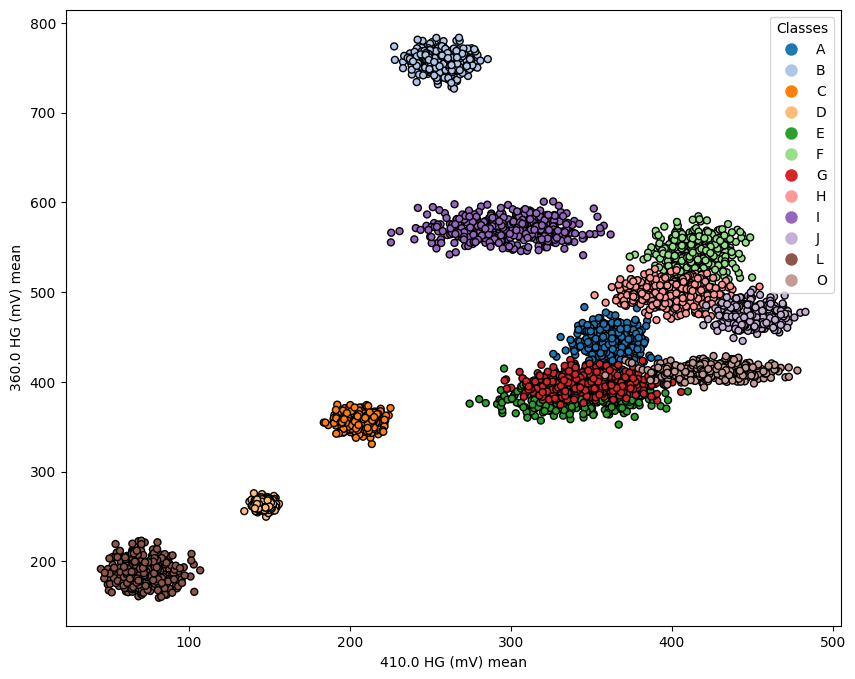

In [214]:
subset_freqs = list(range(100, 600, 10))

X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)
X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)

## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

def plot_data_visualization(X_train, y_train, var1, var2):
    
    # Get unique classes and encode
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_train)
    n_classes = len(np.unique(y_encoded))
    
    # Create custom colormap with only needed colors
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Get all 20 colors
    colors = colors[:n_classes]  # Take only needed colors
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train[var1], 
                         X_train[var2],
                         c=y_encoded,
                         cmap=custom_cmap,
                         edgecolor='k', 
                         s=25)
    
    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], 
                                marker='o', 
                                color='w',
                                markerfacecolor=colors[i], 
                                label=class_name,
                                markersize=10) 
                      for i, class_name in enumerate(le.classes_)]
    
    plt.legend(handles=legend_elements, title="Classes")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

plot_data_visualization(X_train, y_train, var1, var2)